```Performance Optimization with torch compiler```
- Model Size: 0.05M

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
torch.set_float32_matmul_precision('high')

## Hyperparameters and Configuration

In [3]:
# Modified hyperparameters
SEQUENCE_LENGTH = 256

EMBEDDING_DIM = 64
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 1024
EPOCHS = 5
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 2
DROPOUT = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [4]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [5]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [6]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [7]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [8]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003599
Validation dataset size: 111283


## Data Visualization

In [9]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([1024, 256])
Target shape: torch.Size([1024, 256])
Sample 1: ------------------------------
Input sequence : hat retires I'll take him for a Volsce,And he shall feel mine edge.MARCIUS:All the contagion of the south light on you,You shames of Rome! you herd of--Boils and plaguesPlaster you o'er, that you may be abhorr'dFurther than seen and one infect anoth
Target sequence: at retires I'll take him for a Volsce,And he shall feel mine edge.MARCIUS:All the contagion of the south light on you,You shames of Rome! you herd of--Boils and plaguesPlaster you o'er, that you may be abhorr'dFurther than seen and one infect anothe

Sample 2: ------------------------------
Input sequence : trange, the like yet never heard of.I think it cites us, brother, to the field,That we, the sons of brave Plantagenet,Each one already blazing by our meeds,Should notwithstanding join our lights togetherAnd over-shine the earth as this the world.What
Target sequence: range, the like yet nev

## Training Function

In [10]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [11]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [12]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = [] # 에포크별 평균 VRAM 사용량 리스트로 변경 가능 또는 배치별 VRAM 사용량 리스트 유지
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        
        # Training phase
        # epoch_train_losses는 (step, epoch, loss_value) 튜플의 리스트
        epoch_train_losses_list, step, epoch_vram_usage_list = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses_list)
        if epoch_vram_usage_list: # CUDA 사용 시에만 vram_usage가 채워짐
             all_vram_usages.extend(epoch_vram_usage_list) # 배치별 VRAM 사용량 모두 저장

        # 현재 에포크의 평균 훈련 로스 계산
        avg_epoch_train_loss = 0
        if epoch_train_losses_list:
            avg_epoch_train_loss = np.mean([loss_tuple[2] for loss_tuple in epoch_train_losses_list])
        
        # Validation phase
        # epoch_val_losses는 (step, epoch, loss_value) 튜플의 리스트
        epoch_val_losses_list = validate(model, val_loader, criterion, device, epoch, step) # validate의 step은 해당 에포크 종료 시점의 step
        all_val_losses.extend(epoch_val_losses_list)
        
        # 현재 에포크의 평균 검증 로스 계산
        avg_epoch_val_loss = 0
        if epoch_val_losses_list:
            avg_epoch_val_loss = np.mean([loss_tuple[2] for loss_tuple in epoch_val_losses_list])
            
        epoch_time = time.time() - epoch_start_time
        
        avg_epoch_vram_str = ""
        if epoch_vram_usage_list: # CUDA 사용 시
            avg_epoch_vram = np.mean(epoch_vram_usage_list)
            avg_epoch_vram_str = f', Avg VRAM: {avg_epoch_vram:.2f}MB'

        print(f'Epoch {epoch}/{epochs}, Avg Train Loss: {avg_epoch_train_loss:.4f}, '
              f'Avg Val Loss: {avg_epoch_val_loss:.4f}, Epoch Time: {epoch_time:.2f}s{avg_epoch_vram_str}')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    
    # all_vram_usages는 모든 배치의 VRAM 사용량을 담고 있으므로, 전체 평균을 계산할 수 있음
    # overall_avg_vram = np.mean(all_vram_usages) if all_vram_usages else 0
    # print(f"Overall Average VRAM Usage: {overall_avg_vram:.2f} MB")
    
    return model, train_losses_df, val_losses_df

In [14]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [15]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [16]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [17]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [18]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [19]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [20]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

In [21]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [22]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## Original minGRU

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional, Union
from torch.nn import RMSNorm # 사용자의 환경에 RMSNorm이 torch.nn에 있다고 가정합니다.

class CausalDepthWiseConv1d(nn.Module):
    """
    인과적(Causal) 1D 깊이별 분리형 컨볼루션(Depth-wise Separable Convolution) 모듈.
    깊이별 컨볼루션과 점별 컨볼루션을 순차적으로 적용합니다.
    인과성을 유지하기 위해 시퀀스의 왼쪽에 패딩을 추가하여,
    시간 t의 출력은 시간 t까지의 입력에만 의존하도록 합니다.
    """
    def __init__(self, dimension: int, kernel_size: int):
        """
        Args:
            dimension (int): 입력 및 출력 채널의 수.
            kernel_size (int): 컨볼루션 커널의 크기.
        """
        super().__init__()
        self.kernel_size = kernel_size
        # 인과적 패딩 계산: (커널 크기 - 1) 만큼 왼쪽에, 0만큼 오른쪽에 패딩.
        self.causal_padding = (self.kernel_size - 1, 0)

        self.depthwise_pointwise_conv = nn.Sequential(
            # 깊이별 컨볼루션: 각 입력 채널에 대해 독립적인 필터를 적용.
            nn.Conv1d(dimension, dimension, kernel_size=kernel_size, groups=dimension),
            # 점별 컨볼루션: 채널 정보를 혼합하기 위한 1x1 컨볼루션.
            nn.Conv1d(dimension, dimension, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): 입력 텐서. 형태: (배치 크기, 시퀀스 길이, 채널 수).
        Returns:
            torch.Tensor: 출력 텐서. 형태: (배치 크기, 시퀀스 길이, 채널 수).
        """
        # Conv1D를 위해 (배치 크기, 채널 수, 시퀀스 길이) 형태로 변경.
        x_transposed = x.transpose(1, 2)
        # 시퀀스 왼쪽에 인과적 패딩 적용.
        x_padded = F.pad(x_transposed, self.causal_padding)
        # 깊이별-점별 컨볼루션 적용.
        x_conv_out = self.depthwise_pointwise_conv(x_padded)
        # 다시 (배치 크기, 시퀀스 길이, 채널 수) 형태로 변경.
        return x_conv_out.transpose(1, 2)


class MinGRUCoreOps:
    """
    MinGRU의 핵심 수학적 연산을 위한 정적 메소드들을 포함하는 클래스.
    MinGRU의 수학적 공식에 기반한 함수들이며, 사용자 정의 활성화 함수 및
    순환적 업데이트를 위한 병렬 스캔 연산 등을 포함합니다.
    """

    @staticmethod
    def g_activation(x: torch.Tensor) -> torch.Tensor:
        """
        MinGRU를 위한 사용자 정의 활성화 함수 'g'.
        g(x) = x + 0.5  (x >= 0 인 경우)
        g(x) = sigmoid(x) (x < 0 인 경우)
        """
        output = torch.empty_like(x)
        positive_mask = x >= 0
        # 양수 또는 0인 경우
        output[positive_mask] = x[positive_mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)
        # 음수인 경우
        output[~positive_mask] = torch.sigmoid(x[~positive_mask])
        return output

    @staticmethod
    def log_g_activation(x: torch.Tensor) -> torch.Tensor:
        """
        사용자 정의 활성화 함수 'g'의 로그(logarithm) 값.
        log_g(x) = log(x + 0.5) (x >= 0 인 경우)
        log_g(x) = log(sigmoid(x)) = -softplus(-x) (x < 0 인 경우)
        수치적 안정성을 위해 사용됩니다.
        """
        output = torch.empty_like(x)
        positive_mask = x >= 0
        # 양수 또는 0인 경우
        output[positive_mask] = (x[positive_mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)).log().to(x.dtype)
        # 음수인 경우 (log(sigmoid(x)) = -softplus(-x))
        output[~positive_mask] = (-F.softplus(-x[~positive_mask])).to(x.dtype)
        return output

    @staticmethod
    def _log_space_parallel_scan(log_a_terms: torch.Tensor, log_b_terms: torch.Tensor) -> torch.Tensor:
        """
        로그 공간에서의 병렬 스캔(누적) 연산.
        MinGRU의 순환 관계를 병렬적으로 계산하기 위해 사용됩니다.
        x_t = a_t * x_{t-1} + b_t  형태의 연산을 로그 공간에서 수행합니다.
        (원문: _parallel_scan_log)

        Args:
            log_a_terms (torch.Tensor): 로그 스케일의 'a' 항들. (log(a_t))
            log_b_terms (torch.Tensor): 로그 스케일의 'b' 항들. (log(b_t))
                                      첫 번째 요소는 log(x_0) * a_0 (초기 상태 관련 항)을 포함할 수 있음.
        Returns:
            torch.Tensor: 병렬 스캔 결과의 지수 값 (원래 스케일). (exp(log_x_t))
        """
        # log_a_terms의 누적 합을 계산 (alpha_star). 시퀀스 차원(dim=1)을 따라 누적.
        # 패딩은 초기 조건(x_0)을 처리하기 위함.
        padding_dims = [0] * (log_a_terms.ndim - 2) * 2 + [1, 0] # (..., 1, 0) sequence dimension padding
        alpha_star = F.pad(torch.cumsum(log_a_terms, dim=1), padding_dims)

        # log_b_terms - alpha_star 항에 대해 로그-합-지수(logsumexp) 누적을 수행.
        # 이는 x_0 항과 b_t / (a_1*...*a_t) 항들의 누적 합을 로그 공간에서 계산하는 것과 유사.
        x0_plus_b_star_contribution = torch.logcumsumexp(log_b_terms - alpha_star, dim=1)

        # 최종 로그 스케일 결과: alpha_star + x0_plus_b_star_contribution
        log_x_sequence = alpha_star + x0_plus_b_star_contribution
        return torch.exp(log_x_sequence)

    @staticmethod
    def _mingru_recurrent_update_log_space(log_previous_hidden_state: torch.Tensor,
                                           gate_z: torch.Tensor,
                                           candidate_hidden: torch.Tensor) -> torch.Tensor:
        """
        MinGRU의 순환 업데이트를 로그 공간에서 병렬적으로 수행.
        h_t = (1-z_t)*h_{t-1} + z_t*h_tilde_t
        (원문: _mingru_parallel)

        Args:
            log_previous_hidden_state (torch.Tensor): 이전 은닉 상태의 로그 값 (log(h_{t-1})).
                                                     형태: (배치, 1, 은닉 차원) - 시퀀스의 첫 번째 요소에 해당.
            gate_z (torch.Tensor): 게이트 z_t 값. 형태: (배치, 시퀀스 길이, 은닉 차원).
            candidate_hidden (torch.Tensor): 후보 은닉 상태 h_tilde_t 값. 형태: (배치, 시퀀스 길이, 은닉 차원).

        Returns:
            torch.Tensor: 계산된 은닉 상태 시퀀스 h_t. 형태: (배치, 시퀀스 길이, 은닉 차원).
        """
        # log(z_t) = -softplus(-gate_z)  (log(sigmoid(gate_z)))
        log_z = -F.softplus(-gate_z)
        # log(1-z_t) = -softplus(gate_z) (log(sigmoid(-gate_z)))
        log_one_minus_z = -F.softplus(gate_z)

        # log(h_tilde_t) 계산
        log_candidate_hidden = MinGRUCoreOps.log_g_activation(candidate_hidden)

        # 병렬 스캔을 위한 log_b 항 구성:
        # 첫 번째 항은 log(h_prev) (실제로는 log(h_0) * (1-z_0)에 대응하는 항으로 변환됨)
        # 나머지 항은 log(z_t) + log(h_tilde_t)
        # log_previous_hidden_state는 (B, 1, H) 이므로, dim=1로 concat
        log_b_for_scan = torch.cat((log_previous_hidden_state, log_z + log_candidate_hidden), dim=1)

        # log_a 항은 log(1-z_t)
        # 병렬 스캔 실행
        # h_sequence_plus_initial 결과는 h_0, h_1, ..., h_T-1 을 포함
        h_sequence_plus_initial = MinGRUCoreOps._log_space_parallel_scan(log_one_minus_z, log_b_for_scan)

        # 초기 상태 h_0를 제외한 h_1, ..., h_T-1 시퀀스 반환
        return h_sequence_plus_initial[:, 1:]

    @staticmethod
    def calculate_output_sequence(gate_z: torch.Tensor,
                                  candidate_hidden: torch.Tensor,
                                  initial_hidden_state: torch.Tensor) -> torch.Tensor:
        """
        주어진 게이트, 후보 은닉 상태, 초기 은닉 상태를 사용하여 MinGRU의 출력 시퀀스를 계산.
        (원문: mingru_gate_hidden)

        Args:
            gate_z (torch.Tensor): 게이트 z_t 값.
            candidate_hidden (torch.Tensor): 후보 은닉 상태 h_tilde_t 값.
            initial_hidden_state (torch.Tensor): 초기 은닉 상태 h_0 값.

        Returns:
            torch.Tensor: 계산된 은닉 상태 시퀀스.
        """
        # 수치적 안정성을 위해 작은 epsilon 값을 더한 후 로그 변환.
        epsilon = torch.tensor(1e-12, dtype=initial_hidden_state.dtype, device=initial_hidden_state.device)
        log_initial_hidden_state = (initial_hidden_state + epsilon).log()

        return MinGRUCoreOps._mingru_recurrent_update_log_space(log_initial_hidden_state, gate_z, candidate_hidden)


class MinGRU(nn.Module):
    """
    MinGRU (Minimal Gated Recurrent Unit) 모델.
    여러 MinGRU 레이어를 쌓아 구성할 수 있습니다.
    """
    # 타입 힌트 (JIT 호환성을 위해 Final 제거)
    layer_dims: Tuple[int, ...]
    num_internal_layers: int

    def __init__(
        self,
        input_dim: int,
        hidden_dims_list: List[int],
        use_bias: bool = True,
        apply_layer_norm: bool = True,
        dropout_probability: float = 0.1,
        use_residual: bool = True,
    ):
        """
        Args:
            input_dim (int): 입력 특징의 차원.
            hidden_dims_list (List[int]): 각 MinGRU 레이어의 은닉 차원 리스트.
            use_bias (bool): 선형 계층에서 편향을 사용할지 여부.
            apply_layer_norm (bool): 각 레이어 내부에 LayerNorm을 적용할지 여부.
            dropout_probability (float): 드롭아웃 확률. 0이면 드롭아웃을 적용하지 않음.
            use_residual (bool): 잔차 연결(residual connection)을 사용할지 여부.
        """
        super().__init__()
        self.layer_dims = tuple([input_dim] + hidden_dims_list) # 입력 차원 + 각 레이어 은닉 차원
        self.num_internal_layers = len(hidden_dims_list) # MinGRU 레이어의 수
        self.dropout_probability = dropout_probability
        self.use_residual = use_residual
        self.apply_internal_norm = apply_layer_norm

        torch_layers_list = [] # nn.ModuleList로 관리될 레이어 모듈들
        # 각 레이어의 입력 차원과 출력 차원을 순회
        layer_dim_pairs = zip(self.layer_dims[:-1], self.layer_dims[1:])

        for layer_idx, (current_input_dim, current_output_dim) in enumerate(layer_dim_pairs):
            layer_modules_dict = {} # nn.ModuleDict로 관리될 특정 레이어의 모듈들

            if self.apply_internal_norm:
                layer_modules_dict["norm"] = torch.nn.LayerNorm(current_input_dim)
            else:
                layer_modules_dict["norm"] = torch.nn.Identity()

            # 게이트(z_t)와 후보 은닉 상태(h_tilde_t)를 계산하기 위한 선형 계층
            layer_modules_dict["gate_and_candidate_proj"] = torch.nn.Linear(current_input_dim, current_output_dim * 2, bias=use_bias)

            # 잔차 연결을 위한 차원 정렬용 선형 계층 (입력과 출력 차원이 다를 경우)
            if use_residual and current_input_dim != current_output_dim:
                layer_modules_dict["residual_align_proj"] = torch.nn.Linear(current_input_dim, current_output_dim, bias=False)
            else:
                layer_modules_dict["residual_align_proj"] = torch.nn.Identity()

            # 드롭아웃 (마지막 레이어 제외)
            if self.dropout_probability > 0.0 and layer_idx < (self.num_internal_layers - 1):
                layer_modules_dict["dropout"] = torch.nn.Dropout(p=self.dropout_probability)
            else:
                layer_modules_dict["dropout"] = torch.nn.Identity()

            torch_layers_list.append(torch.nn.ModuleDict(layer_modules_dict))

        self.layers = torch.nn.ModuleList(torch_layers_list)
        self.apply(self._init_weights)  # 가중치 초기화
        
    def _init_weights(self, module: nn.Module):
        # 선형 레이어 가중치 초기화 (게이트 편향 특수 처리 포함)
        for i in range(self.num_internal_layers):
            layer_components = self.layers[i]
            output_dim = self.layer_dims[i+1]
            # 1. 잔차 연결 프로젝션 레이어 초기화 (일반)
            if isinstance(layer_components["residual_align_proj"], nn.Linear):
                nn.init.normal_(layer_components["residual_align_proj"].weight, mean=0.0, std=0.02)
            
            # 2. 게이트 및 후보 은닉 상태 프로젝션 레이어 특별 초기화
            gate_hidden_proj_layer = layer_components["gate_and_candidate_proj"]
            
            # 가중치는 표준 정규분포로 초기화
            nn.init.normal_(gate_hidden_proj_layer.weight, mean=0.0, std=0.02)

            # 편향(bias)은 특별하게 초기화
            if gate_hidden_proj_layer.bias is not None:
                # 편향 텐서는 (output_dim * 2) 크기
                # 앞 절반은 게이트 로짓(gate_logits)용, 뒤 절반은 후보 은닉 상태(candidate_hidden_inputs)용
                
                # 게이트 로짓의 편향을 음수 값으로 초기화 (예: -1.0)
                # sigmoid(음수)는 0에 가까워져, z_t가 작아짐
                # h_t = (1-z_t)*h_{t-1} + z_t*h_tilde_t 에서 (1-z_t)가 커지므로
                # 학습 초기에 이전 은닉 상태 h_{t-1}를 더 많이 유지하도록 유도하여 안정적인 학습에 도움을 줍니다.
                nn.init.constant_(gate_hidden_proj_layer.bias[:output_dim], -1.0)
                
                # 후보 은닉 상태의 편향은 0으로 초기화
                nn.init.zeros_(gate_hidden_proj_layer.bias[output_dim:])
            

    def init_hidden_states(self, input_tensor: torch.Tensor) -> List[torch.Tensor]:
        """
        각 MinGRU 레이어의 초기 은닉 상태를 생성합니다.
        MinGRU의 g 활성화 함수를 사용하여 0으로 초기화된 텐서를 변환합니다.

        Args:
            input_tensor (torch.Tensor): 입력 텐서. 배치 크기, 자료형, 장치 정보를 얻기 위해 사용.
                                         형태: (배치 크기, 시퀀스 길이, 입력 차원).
        Returns:
            List[torch.Tensor]: 각 레이어의 초기 은닉 상태 리스트.
                                각 텐서의 형태: (배치 크기, 1, 해당 레이어의 은닉 차원).
        """
        batch_size = input_tensor.shape[0]
        initial_states = []
        for hidden_dim in self.layer_dims[1:]: # 각 레이어의 출력(은닉) 차원에 대해
            # (배치 크기, 1, 은닉 차원) 형태의 0 텐서 생성 후 g_activation 적용
            zeros = input_tensor.new_zeros(batch_size, 1, hidden_dim, dtype=input_tensor.dtype)
            initial_states.append(MinGRUCoreOps.g_activation(zeros))
        return initial_states

    def forward(
        self,
        input_sequence: torch.Tensor,
        initial_hidden_states_list: Optional[List[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        MinGRU 모델의 순방향 전파를 수행합니다.

        Args:
            input_sequence (torch.Tensor): 입력 시퀀스. 형태: (배치 크기, 시퀀스 길이, 입력 차원).
            initial_hidden_states_list (Optional[List[torch.Tensor]]):
                제공될 경우 사용할 초기 은닉 상태 리스트.
                None이면 내부적으로 init_hidden_states를 호출하여 생성.

        Returns:
            Tuple[torch.Tensor, List[torch.Tensor]]:
                - 최종 레이어의 출력 시퀀스. 형태: (배치 크기, 시퀀스 길이, 마지막 레이어의 은닉 차원).
                - 각 레이어의 다음 시퀀스를 위한 마지막 은닉 상태 리스트.
                  각 텐서의 형태: (배치 크기, 1, 해당 레이어의 은닉 차원).
        """
        if initial_hidden_states_list is None:
            hidden_states_for_layers = self.init_hidden_states(input_sequence)
        else:
            hidden_states_for_layers = initial_hidden_states_list

        current_layer_input_sequence = input_sequence
        next_step_hidden_states_list: List[torch.Tensor] = []

        for layer_idx in range(self.num_internal_layers):
            layer_module_components = self.layers[layer_idx]

            normalized_sequence = layer_module_components["norm"](current_layer_input_sequence)
            # 게이트와 후보 은닉 상태를 한 번에 계산 후 분리
            gate_values, candidate_hidden_states = layer_module_components["gate_and_candidate_proj"](normalized_sequence).chunk(2, dim=2)

            # 현재 레이어의 초기(또는 이전 스텝의) 은닉 상태
            previous_hidden_state_for_this_layer: torch.Tensor = hidden_states_for_layers[layer_idx]

            # MinGRU 순환 연산
            output_sequence_current_layer = MinGRUCoreOps.calculate_output_sequence(
                gate_values, candidate_hidden_states, previous_hidden_state_for_this_layer
            )
            # 다음 스텝(또는 다음 시퀀스)을 위한 마지막 은닉 상태 저장
            next_step_hidden_states_list.append(output_sequence_current_layer[:, -1:])

            if self.use_residual:
                residual_input = layer_module_components["residual_align_proj"](current_layer_input_sequence)
                output_sequence_current_layer = output_sequence_current_layer + residual_input

            current_layer_input_sequence = layer_module_components["dropout"](output_sequence_current_layer)

        return current_layer_input_sequence, next_step_hidden_states_list


class SwiGLUFFN(nn.Module):
    """
    SwiGLU 활성화 함수를 사용하는 FFN (FeedForward Network) 모듈.
    일반적으로 트랜스포머 모델에서 사용됩니다.
    """
    def __init__(self, dimension: int, expansion_factor: float = 2.0, dropout: float = 0.1):
        """
        Args:
            dimension (int): 입력 및 출력 차원.
            expansion_factor (float): 내부 은닉 차원을 결정하기 위한 확장 비율.
                                      실제 은닉 차원은 dimension * expansion_factor * (2/3) 근사.
            dropout (float): 드롭아웃 확률.
        """
        super().__init__()
        # 내부 은닉 차원 계산 (일반적으로 2/3는 GLU 계열에서 사용됨)
        # 또한, 보통 하드웨어 가속을 위해 8의 배수로 맞춤.
        hidden_dimension = int(dimension * expansion_factor * (2/3))
        hidden_dimension = (hidden_dimension + 7) // 8 * 8 # 8의 배수로 올림

        self.gate_proj = nn.Linear(dimension, hidden_dimension, bias=False) # W_gate
        self.up_proj = nn.Linear(dimension, hidden_dimension, bias=False)   # W_up
        self.down_proj = nn.Linear(hidden_dimension, dimension, bias=False) # W_down
        self.dropout_layer = nn.Dropout(dropout)
        self.activation_fn = nn.SiLU() # Swish 또는 Sigmoid Linear Unit

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        SwiGLU FFN의 순방향 전파.
        Output = Dropout(W_down(SiLU(W_gate(x)) * W_up(x)))
        """
        gated_x = self.activation_fn(self.gate_proj(x))
        activated_x = gated_x * self.up_proj(x)
        return self.dropout_layer(self.down_proj(activated_x))

class minGRULM(nn.Module):
    """
    MinGRU를 핵심 순환 블록으로 사용하는 전체 언어 모델 아키텍처 (버전 3).
    임베딩, 선택적 컨볼루션, MinGRU 스택, FFN, 최종 정규화 및 출력 프로젝션을 포함합니다.
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        mingru_hidden_dims_config: Union[int, List[int]], # MinGRU 레이어들의 은닉 차원 설정
        num_mingru_layers: Optional[int] = None, # hidden_dims_config가 int일 경우 레이어 수
        dropout_rate: float = 0.1,
        rms_norm_epsilon: float = 1e-8,
        use_convolution_block: bool = True,
        conv_kernel_size: int = 3,
        ffn_expansion_factor: float = 1.0 # SwiGLUFFN의 확장 비율
    ):
        super().__init__()

        # MinGRU 내부 레이어들의 은닉 차원 리스트 결정
        if isinstance(mingru_hidden_dims_config, int):
            if num_mingru_layers is None or num_mingru_layers < 1:
                raise ValueError("`num_mingru_layers`는 `mingru_hidden_dims_config`가 정수일 때 양의 정수여야 합니다.")
            actual_mingru_hidden_dims = [mingru_hidden_dims_config] * num_mingru_layers
        elif isinstance(mingru_hidden_dims_config, list):
            if not mingru_hidden_dims_config:
                raise ValueError("`mingru_hidden_dims_config` 리스트는 비어있을 수 없습니다.")
            actual_mingru_hidden_dims = mingru_hidden_dims_config
        else:
            raise TypeError("`mingru_hidden_dims_config`는 정수 또는 정수 리스트여야 합니다.")

        # MinGRU 모듈의 입력 및 출력 차원
        first_mingru_layer_dim = actual_mingru_hidden_dims[0]
        last_mingru_layer_dim = actual_mingru_hidden_dims[-1]

        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)

        # 임베딩 차원을 첫 번째 MinGRU 레이어의 입력 차원으로 프로젝션
        if embedding_dim != first_mingru_layer_dim:
            self.embedding_to_mingru_projection = nn.Linear(embedding_dim, first_mingru_layer_dim)
        else:
            self.embedding_to_mingru_projection = nn.Identity()

        # 선택적 인과적 깊이별 컨볼루션 블록
        if use_convolution_block:
            self.causal_conv_block = CausalDepthWiseConv1d(first_mingru_layer_dim, conv_kernel_size)
        else:
            self.causal_conv_block = nn.Identity()

        # MinGRU 전 정규화
        self.norm_before_mingru = RMSNorm(first_mingru_layer_dim, eps=rms_norm_epsilon)

        self.mingru_stack = MinGRU(
            input_dim=first_mingru_layer_dim,
            hidden_dims_list=actual_mingru_hidden_dims,
            apply_layer_norm=True, # MinGRU 내부 LayerNorm 사용
            dropout_probability=dropout_rate,
            use_residual=True      # MinGRU 내부 잔차 연결 사용
        )

        # MinGRU 블록의 입력과 출력 차원이 다를 경우 잔차 연결을 위한 프로젝션
        if first_mingru_layer_dim != last_mingru_layer_dim:
            self.mingru_residual_projection = nn.Linear(first_mingru_layer_dim, last_mingru_layer_dim)
        else:
            self.mingru_residual_projection = nn.Identity()

        # MinGRU 후, FFN 전 정규화
        self.norm_after_mingru_before_ffn = RMSNorm(last_mingru_layer_dim, eps=rms_norm_epsilon)
        self.ffn_block = SwiGLUFFN(
            dimension=last_mingru_layer_dim,
            expansion_factor=ffn_expansion_factor,
            dropout=dropout_rate
        )

        # 최종 정규화 및 로짓 프로젝션
        self.final_output_norm = RMSNorm(last_mingru_layer_dim, eps=rms_norm_epsilon)
        self.to_logits_projection = nn.Linear(last_mingru_layer_dim, vocab_size)
        
        self.apply(self._init_weights)

    def _init_weights(self, module: nn.Module): # module 인자를 명시적으로 타입 힌트
        """
        모델 내 각 모듈의 가중치를 초기화합니다.
        self.apply() 메소드에 의해 호출됩니다.
        """
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02) 
        elif isinstance(module, nn.Conv1d):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu') # mode='fan_in'이 일반적
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, RMSNorm):
            if hasattr(module, 'weight') and module.weight is not None: # RMSNorm에 weight가 있을 경우
                nn.init.ones_(module.weight)
        elif isinstance(module, nn.LayerNorm): # MinGRU 내부의 LayerNorm 처리
            if hasattr(module, 'weight') and module.weight is not None:
                nn.init.ones_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor: # 반환 타입에서 None 제거, 일반적으로 로짓만 반환
        """
        minGRULM 모델의 순방향 전파.

        Args:
            input_ids (torch.Tensor): 입력 토큰 ID 시퀀스. 형태: (배치 크기, 시퀀스 길이).

        Returns:
            torch.Tensor: 최종 로짓. 형태: (배치 크기, 시퀀스 길이, 어휘 크기).
        """
        # 1. 임베딩 및 초기 프로젝션
        current_hidden_repr = self.token_embedding(input_ids)
        current_hidden_repr = self.embedding_to_mingru_projection(current_hidden_repr)

        # 2. (선택적) 컨볼루션 블록 + 잔차 연결
        residual_conv_input = current_hidden_repr
        if not isinstance(self.causal_conv_block, nn.Identity):
            # 컨볼루션 블록이 Identity가 아닐 때만 연산 (즉, use_convolution_block=True 일 때)
            current_hidden_repr = residual_conv_input + self.causal_conv_block(residual_conv_input)
        # else: current_hidden_repr은 residual_conv_input과 동일하게 유지됨

        # 3. MinGRU 블록 + 잔차 연결
        residual_mingru_input = current_hidden_repr
        mingru_input_normalized = self.norm_before_mingru(residual_mingru_input)
        mingru_output_sequence, _ = self.mingru_stack(mingru_input_normalized) # 다음 은닉 상태는 사용 안함
        current_hidden_repr = self.mingru_residual_projection(residual_mingru_input) + mingru_output_sequence

        # 4. FFN 블록 + 잔차 연결
        residual_ffn_input = current_hidden_repr
        ffn_input_normalized = self.norm_after_mingru_before_ffn(residual_ffn_input)
        current_hidden_repr = residual_ffn_input + self.ffn_block(ffn_input_normalized)

        # 5. 최종 정규화 및 로짓 계산
        final_representation_normalized = self.final_output_norm(current_hidden_repr)
        logits = self.to_logits_projection(final_representation_normalized)

        return logits, _

In [24]:
### Model Initialization
mingru = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [25]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 64]           4,160
├─Linear: 1-2                            [1024, 256, 153]          9,945
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 153]          --
│    └─Sequential: 2-1                   [1024, 153, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 153, 256]          612
│    │    └─Conv1d: 3-2                  [1024, 153, 256]          23,562
├─RMSNorm: 1-4                           [1024, 256, 153]          153
├─MinGRU: 1-5                            [1024, 256, 153]          --
│    └─ModuleList: 2-2                   --                        --
│    │    └─ModuleDict: 3-3              --                        47,430
│    │    └─ModuleDict: 3-4              --                        47,430
├─Identity: 1-6                          [1024, 256, 153]        

Epoch 1/5, Avg Train Loss: 1.6285, Avg Val Loss: 1.5651, Epoch Time: 179.20s, Avg VRAM: 362.96MB


Epoch 2/5, Avg Train Loss: 1.3538, Avg Val Loss: 1.5350, Epoch Time: 178.91s, Avg VRAM: 363.09MB


Epoch 3/5, Avg Train Loss: 1.3128, Avg Val Loss: 1.5366, Epoch Time: 179.26s, Avg VRAM: 363.37MB


Epoch 4/5, Avg Train Loss: 1.2913, Avg Val Loss: 1.5362, Epoch Time: 179.37s, Avg VRAM: 363.19MB


Epoch 5/5, Avg Train Loss: 1.2771, Avg Val Loss: 1.5352, Epoch Time: 178.88s, Avg VRAM: 362.85MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina, sir,
For, for what mave I know the traitor's morning.

MARCIUS:
Good sayks, without it was to flight men?

PAULINA:
Which good there?

AUTOLYCUS:
But has my pale so, and so that; methinks of sir!
Why art mine unhope; for all her was the imagice,
Thou art be exercing comes, I let mew ear
To what I, when he was not c

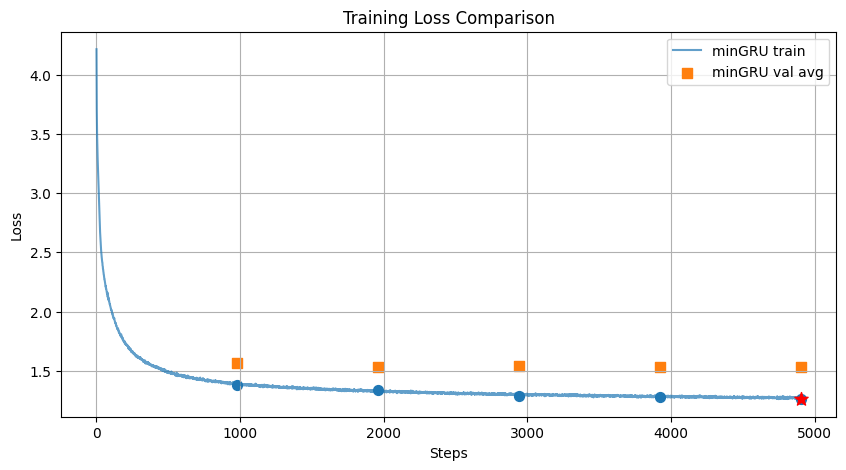

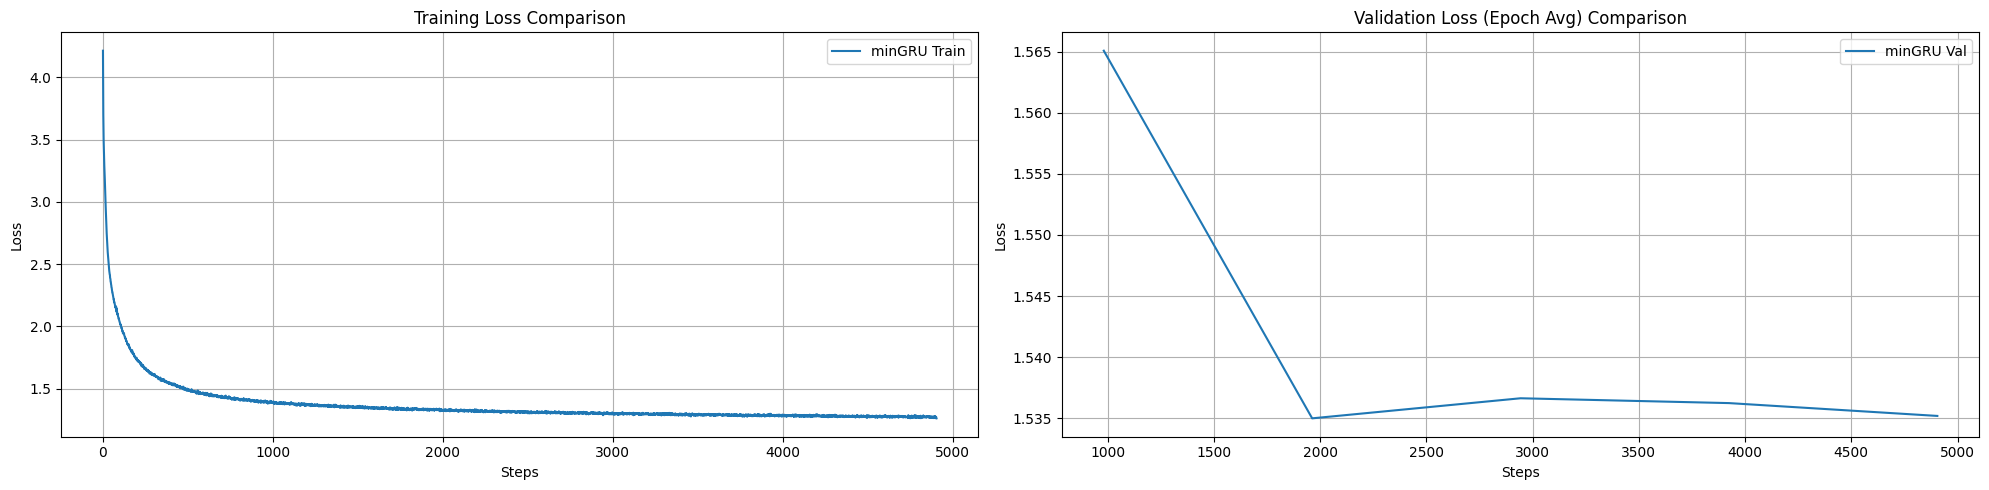

In [26]:
train_and_test("minGRU", mingru, start_text)

## Restructure minGRU
- 기존 모델 구조는 torch.compile과 호환되기 어려운 구조이므로, 이전에 구현했던 구조 중 하나인 llama like structure를 이용

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math  # math.log 및 상수 사용을 위함
from tqdm import tqdm  # tqdm 임포트 추가


def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))


def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1)
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :])
    return output_hidden_states


class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.expansion_factor = expansion_factor  # GRU 셀 내부의 확장 계수
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'to_hidden_and_gate' in name or 'to_out' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None:
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, input_size]
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x)  # [B, L, internal_expanded_dim * 2]
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1)

        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full(
            (B, 1, self.internal_expanded_dim),
            math.log(self.epsilon),
            device=x.device,
            dtype=x.dtype
        )
        log_vals = torch.cat([log_h0_val, log_B], dim=1)  # [B, L+1, internal_expanded_dim]
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals)  # [B, L, internal_expanded_dim]

        output = self.to_out(h_expanded_scan_out)  # [B, L, hidden_size]
        return output


class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma


class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim),
            nn.Conv1d(dim, dim, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        if x.dim() == 2:
            x = x.unsqueeze(0)
        x_transposed = x.transpose(1, 2)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.0)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2)
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0)
        return x_restored


class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)

        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False)
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1)
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states)
        return self.w2(hidden_states)


class minGRULM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1,
        expansion_factor_gru: float = 1.0,
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        ffn_expansion_factor: float = 2.0,
        conv_kernel_size: int = 3            # ← 여기에 컨볼루션 커널 크기 파라미터 추가
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim)
        # ─── 입력 프로젝션 이후에 CausalDepthWiseConv1d 모듈을 추가 ───
        self.conv = CausalDepthWiseConv1d(hidden_dim, conv_kernel_size)
        # ─────────────────────────────────────────────────────────

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim,
                expansion_factor=ffn_expansion_factor,
                dropout=dropout
            )

            self.layers.append(nn.ModuleList([
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ParallelLogMinGRU(
                    input_size=hidden_dim,
                    hidden_size=hidden_dim,
                    expansion_factor=expansion_factor_gru,
                    epsilon=epsilon_gru
                ),
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ffn_layer,
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps)
        self.to_vocab = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor):
        h = self.embedding(x)                    # [B, L, embedding_dim]
        h = self.input_projection(h)             # [B, L, hidden_dim]

        # ─── input_projection 직후에 causal conv1d 적용 ───
        h = self.conv(h)                         # [B, L, hidden_dim]
        # ───────────────────────────────────────────────────

        for block_idx, block_modules in enumerate(self.layers):
            norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            # ┌── GRU 블록 + 잔차
            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out
            # └───────────────────────

            # ┌── FFN 블록 + 잔차
            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff)
            h = h_ff_residual_source + h_ff_out
            # └───────────────────────

            h = dropout_block_output(h)

        h = self.final_norm(h)
        logits = self.to_vocab(h)
        return logits, None

In [28]:
### Model Initialization
mingru2 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [29]:
from torchinfo import summary

summary(mingru2, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 64]           4,160
├─Linear: 1-2                            [1024, 256, 153]          9,945
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 153]          --
│    └─Sequential: 2-1                   [1024, 153, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 153, 256]          612
│    │    └─Conv1d: 3-2                  [1024, 153, 256]          23,562
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 256, 153]          153
│    │    └─ParallelLogMinGRU: 3-4       [1024, 256, 153]          47,124
│    │    └─RMSNorm: 3-5                 [1024, 256, 153]          153
│    │    └─SwiGLUFFN: 3-6               [1024, 256, 153]          1

Epoch 1/5, Avg Train Loss: 1.5825, Avg Val Loss: 1.5210, Epoch Time: 106.76s, Avg VRAM: 60.70MB


Epoch 2/5, Avg Train Loss: 1.2721, Avg Val Loss: 1.5121, Epoch Time: 107.28s, Avg VRAM: 60.70MB


Epoch 3/5, Avg Train Loss: 1.2150, Avg Val Loss: 1.5203, Epoch Time: 107.01s, Avg VRAM: 60.70MB


Epoch 4/5, Avg Train Loss: 1.1852, Avg Val Loss: 1.5423, Epoch Time: 106.80s, Avg VRAM: 60.70MB


Epoch 5/5, Avg Train Loss: 1.1663, Avg Val Loss: 1.5507, Epoch Time: 107.36s, Avg VRAM: 60.70MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina,
From Tiberi; 'tis a fearful I hide,
Even so may be gone. Heaven keep me with my
shaft the surping to praise the tidings, is dead;
He were far from evilland to more and last
Unto the cause of Hear backs from his eye,
Whose gabour is in the lady whereon I saw his
late incapable pleasure of this fool:
'Twas 'twere in y

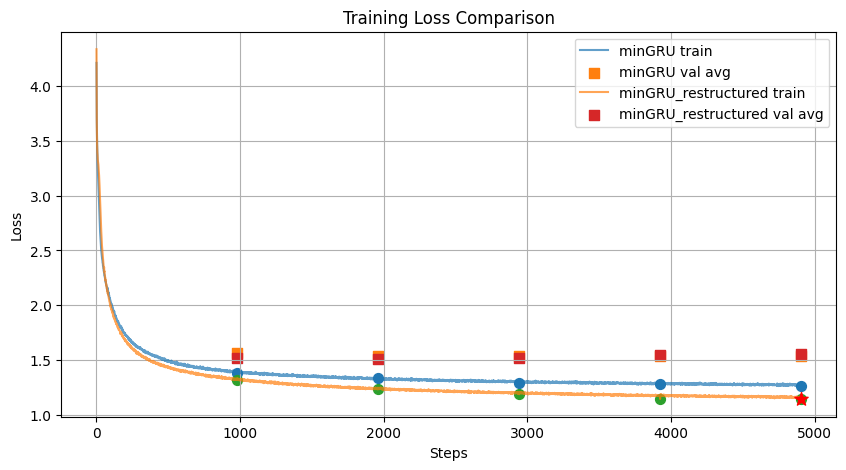

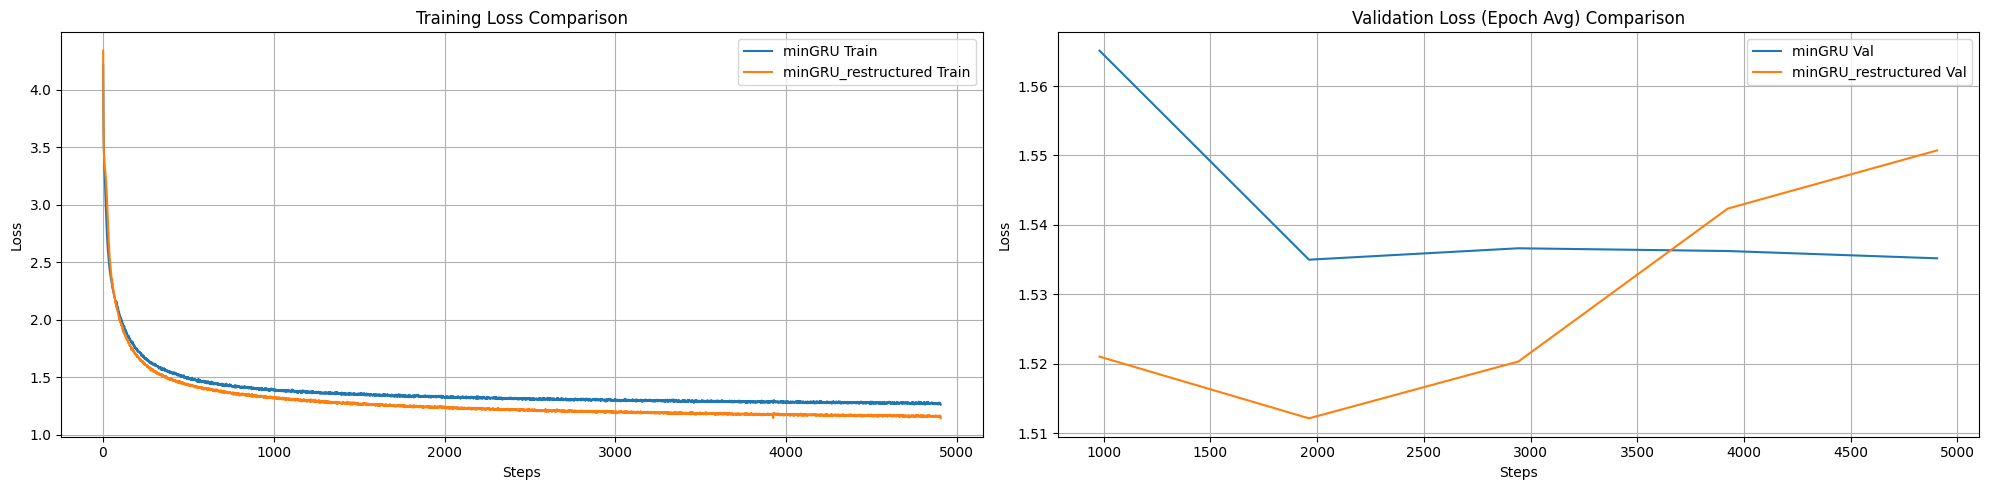

In [30]:
train_and_test("minGRU_restructured", mingru2, start_text)

## Compiled minGRU

In [31]:
def train_and_test2(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # 다양한 컴파일 모드:
        # "default": 좋은 성능과 컴파일 시간의 균형
        # "reduce-overhead": 컴파일 오버헤드 감소 (작은 모델에 유리)
        # "max-autotune": 가장 긴 컴파일 시간, 가장 높은 성능 목표
    model = torch.compile(model, mode="reduce-overhead")
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [32]:
### Model Initialization
mingru3 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [33]:
from torchinfo import summary

summary(mingru3, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 64]           4,160
├─Linear: 1-2                            [1024, 256, 153]          9,945
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 153]          --
│    └─Sequential: 2-1                   [1024, 153, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 153, 256]          612
│    │    └─Conv1d: 3-2                  [1024, 153, 256]          23,562
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 256, 153]          153
│    │    └─ParallelLogMinGRU: 3-4       [1024, 256, 153]          47,124
│    │    └─RMSNorm: 3-5                 [1024, 256, 153]          153
│    │    └─SwiGLUFFN: 3-6               [1024, 256, 153]          1

Epoch 1/5, Avg Train Loss: 1.5729, Avg Val Loss: 1.5005, Epoch Time: 136.66s, Avg VRAM: 13.69MB


Epoch 2/5, Avg Train Loss: 1.2747, Avg Val Loss: 1.4895, Epoch Time: 61.90s, Avg VRAM: 13.68MB


Epoch 3/5, Avg Train Loss: 1.2164, Avg Val Loss: 1.5026, Epoch Time: 60.21s, Avg VRAM: 13.61MB


Epoch 4/5, Avg Train Loss: 1.1850, Avg Val Loss: 1.5155, Epoch Time: 60.48s, Avg VRAM: 13.61MB


Epoch 5/5, Avg Train Loss: 1.1654, Avg Val Loss: 1.5262, Epoch Time: 59.98s, Avg VRAM: 13.61MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina,
And as meet to do the truth of heaven.
If Prits he comes from capial goes,
As there all grown bestowed a blood, i' the point.

SICINIUS:
Madam, farewell:
Why, then my looks on it like a hope of king,
And by darkness, good queen, for this triumphant?
Thy friends and room sworn to me, for joy:
Where is a cot, who would

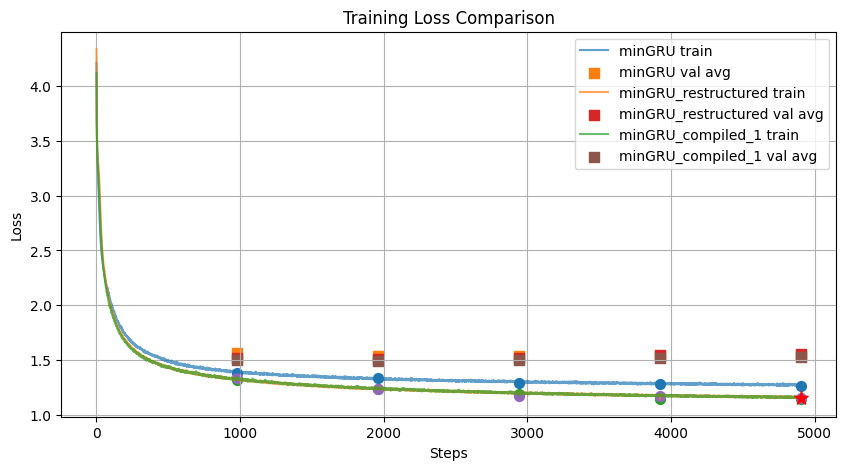

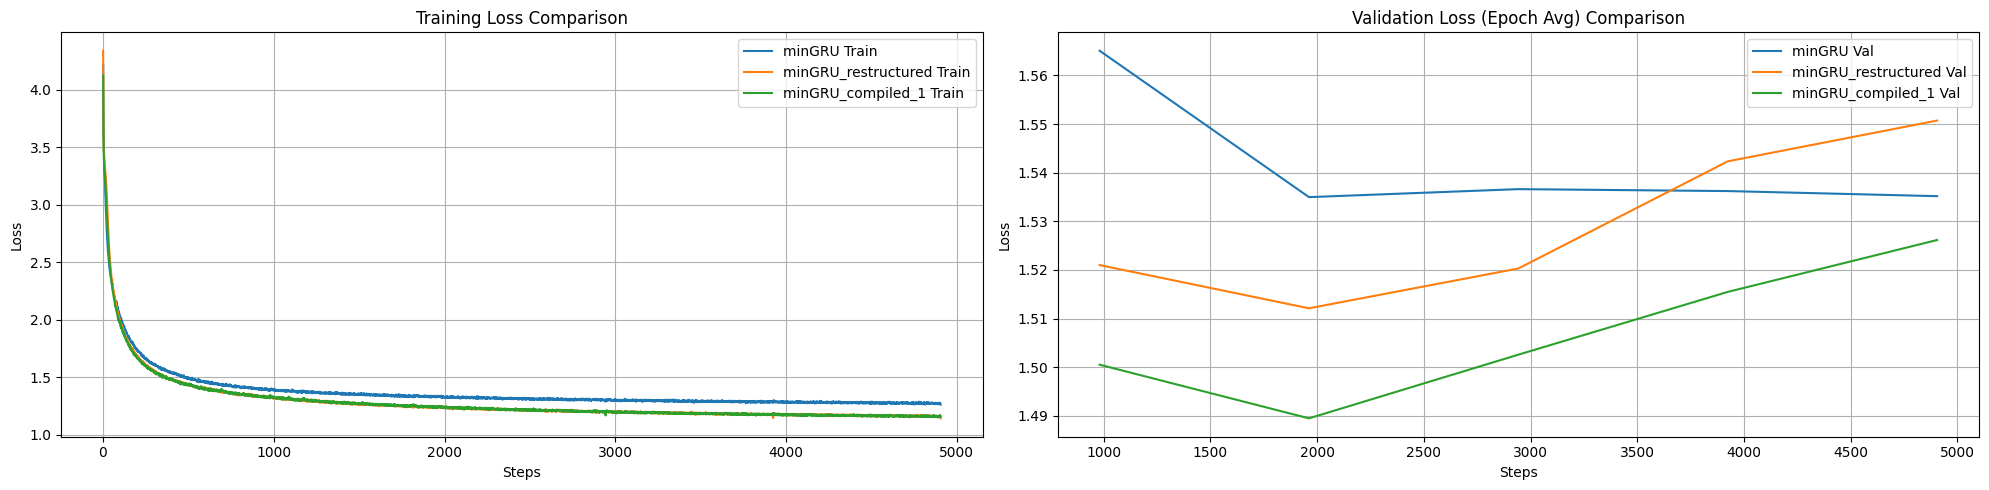

In [34]:
train_and_test2("minGRU_compiled_1", mingru3, start_text)

## Triton minGRU

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm import tqdm

# Triton 라이브러리 임포트
try:
    import triton
    import triton.language as tl
    HAS_TRITON = True
except ImportError:
    HAS_TRITON = False
    print("Triton not found. Please install it to use the optimized GRU implementation.")


# ---------------------------------------------------------------------------------
# │ │
# │ Triton 커널 및 래퍼 함수 (병렬 스캔 알고리즘 적용) │
# │ │
# ---------------------------------------------------------------------------------

@triton.jit
def _softplus(x):
    """
    수치적으로 안정적인 softplus 함수를 Triton으로 구현합니다.
    softplus(x) = log(1 + exp(x))
    """
    return tl.maximum(x, 0) + tl.log(1 + tl.exp(-tl.abs(x)))


@triton.jit
def _log_add_exp(a, b):
    """ 
    수치적으로 안정적인 log(exp(a) + exp(b)) 계산 
    """
    return tl.maximum(a, b) + tl.log(1 + tl.exp(-tl.abs(a - b)))


@triton.jit
def _log_g(x):
    """ Triton 커널 내에서 사용할 log_g 함수 """
    # x >= 0 이면 log(x + 0.5)
    # x < 0 이면 log(sigmoid(x)) = -softplus(-x)
    return tl.where(x >= 0, tl.log(x + 0.5), -_softplus(-x))


@triton.jit
def _gru_scan_op(log_a1, log_b1, log_a2, log_b2):
    """
    GRU 순환 관계를 위한 결합 스캔 연산자입니다.

    
    Args:
        log_a1, log_b1: 첫 번째 요소의 (a, b) 계수
        log_a2, log_b2: 두 번째 요소의 (a, b) 계수
    
    Returns:
        합성된 함수의 (log_a', log_b') 튜플
    """
    # 합성된 'a' 계수: a' = a2 * a1 -> log(a') = log(a2) + log(a1)
    new_log_a = log_a1 + log_a2
    
    # 합성된 'b' 계수: b' = a2 * b1 + b2 -> log(b') = log_add_exp(log(a2) + log(b1), log(b2))
    new_log_b = _log_add_exp(log_a2 + log_b1, log_b2)
    
    return new_log_a, new_log_b


@triton.jit
def _parallel_scan_gru_kernel(
    # --- 입력/출력 텐서 포인터 ---
    h_candidate_input_ptr,
    logits_z_ptr,
    output_ptr,
    # --- 텐서 차원 및 스트라이드 ---
    B, L, H,
    stride_h_cand_b, stride_h_cand_l, stride_h_cand_h,
    stride_logits_z_b, stride_logits_z_l, stride_logits_z_h,
    stride_out_b, stride_out_l, stride_out_h,
    # --- 상수 ---
    epsilon: float,
    # --- Triton 메타 파라미터 ---
    BLOCK_SIZE_L: tl.constexpr, 
):
    # --- 프로그램 ID 계산 ---
    pid = tl.program_id(axis=0)
    b_idx = pid // H
    h_idx = pid % H

    # --- 시퀀스(L) 차원에 대한 오프셋 생성 ---
    l_offsets = tl.arange(0, BLOCK_SIZE_L)
    mask = l_offsets < L

    # --- 처리할 전체 시퀀스의 시작 포인터 계산 ---
    h_cand_seq_ptr = h_candidate_input_ptr + (b_idx * stride_h_cand_b + h_idx * stride_h_cand_h + l_offsets * stride_h_cand_l)
    logits_z_seq_ptr = logits_z_ptr + (b_idx * stride_logits_z_b + h_idx * stride_logits_z_h + l_offsets * stride_logits_z_l)
    
    # --- 전역 메모리에서 전체 시퀀스 데이터 로드 ---
    h_cand_seq = tl.load(h_cand_seq_ptr, mask=mask, other=0.0).to(tl.float32)
    logits_z_seq = tl.load(logits_z_seq_ptr, mask=mask, other=0.0).to(tl.float32)

    # --- 1. 모든 타임스텝에 대한 log_a, log_b 계산 ---
    log_a_seq = -_softplus(logits_z_seq)
    log_b_seq = -_softplus(-logits_z_seq) + _log_g(h_cand_seq)

    # --- 2. 병렬 스캔 수행 ---
    # `tl.associative_scan`을 사용하여 순차 루프 없이 전체 시퀀스를 병렬로 계산합니다.
    # 입력은 (log_a, log_b) 쌍의 시퀀스입니다.
    scanned_log_a, scanned_log_b = tl.associative_scan((log_a_seq, log_b_seq), axis=0, combine_fn=_gru_scan_op)

    # --- 3. 초기 은닉 상태(h0) 적용 ---
    # h_t = (scanned_a_t) * h_0 + scanned_b_t
    # 로그 공간에서 계산: log(h_t) = log_add_exp(scanned_log_a_t + log_h0, scanned_log_b_t)
    log_h0 = tl.log(epsilon)
    log_hidden_states = _log_add_exp(scanned_log_a + log_h0, scanned_log_b)

    # --- 4. 최종 결과 계산 및 저장 ---
    output = tl.exp(log_hidden_states)
    output_seq_ptr = output_ptr + (b_idx * stride_out_b + h_idx * stride_out_h + l_offsets * stride_out_l)
    tl.store(output_seq_ptr, output, mask=mask)


def _parallel_log_min_gru_triton(
    h_candidate_input: torch.Tensor,
    logits_z: torch.Tensor,
    epsilon: float
) -> torch.Tensor:
    """ Triton 커널을 실행하기 위한 Python 래퍼 함수 """
    B, L, H = h_candidate_input.shape
    device = h_candidate_input.device
    
    output = torch.empty((B, L, H), device=device, dtype=h_candidate_input.dtype) 
    
    # BLOCK_SIZE_L은 L보다 크거나 같은 2의 거듭제곱이어야 함
    BLOCK_SIZE_L = triton.next_power_of_2(L)

    grid = (B * H,)

    _parallel_scan_gru_kernel[grid](
        h_candidate_input, logits_z, output,
        B, L, H,
        h_candidate_input.stride(0), h_candidate_input.stride(1), h_candidate_input.stride(2),
        logits_z.stride(0), logits_z.stride(1), logits_z.stride(2),
        output.stride(0), output.stride(1), output.stride(2),
        epsilon,
        BLOCK_SIZE_L=BLOCK_SIZE_L,
    )
    return output


class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.expansion_factor = expansion_factor
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon
        
        self.use_triton = HAS_TRITON

        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'to_hidden_and_gate' in name or 'to_out' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None:
                    nn.init.zeros_(param)
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x)
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1)

        if self.use_triton and x.is_cuda and L > 0:
            h_expanded_scan_out = _parallel_log_min_gru_triton(
                h_candidate_input_expanded, 
                logits_z_expanded, 
                self.epsilon
            )
        else:
            if L == 0:
                return torch.empty(B, 0, self.hidden_size, device=x.device, dtype=x.dtype)
            
            log_A = F.logsigmoid(-logits_z_expanded)
            log_Z_expanded = F.logsigmoid(logits_z_expanded)
            log_h_candidate_contrib_expanded = self._original_log_g(h_candidate_input_expanded)
            log_B = log_Z_expanded + log_h_candidate_contrib_expanded

            log_h0_val = torch.full(
                (B, 1, self.internal_expanded_dim),
                math.log(self.epsilon),
                device=x.device,
                dtype=x.dtype
            )
            log_vals = torch.cat([log_h0_val, log_B], dim=1)
            h_expanded_scan_out = self._original_parallel_scan_log(log_A, log_vals)

        output = self.to_out(h_expanded_scan_out)
        return output

    @staticmethod
    def _original_log_g(x: torch.Tensor) -> torch.Tensor:
        return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

    @staticmethod
    def _original_parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
        log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
        terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
        log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1)
        log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
        output_hidden_states = torch.exp(log_hidden_states[:, 1:, :])
        return output_hidden_states


# =================================================================================
# │ │
# │ 아래는 사용자께서 제공한 나머지 코드 (변경 없음) │
# │ │
# =================================================================================

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_dtype = x.dtype
        variance = x.to(torch.float32).pow(2).mean(dim=-1, keepdim=True)
        return (x * torch.rsqrt(variance + self.eps) * self.gamma).to(input_dtype)


class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim),
            nn.Conv1d(dim, dim, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        if x.dim() == 2:
            x = x.unsqueeze(0)
        x_transposed = x.transpose(1, 2)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.0)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2)
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0)
        return x_restored


class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)

        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False)
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1)
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states)
        return self.w2(hidden_states)


class minGRULM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1,
        expansion_factor_gru: float = 1.0,
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        ffn_expansion_factor: float = 2.0,
        conv_kernel_size: int = 3
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim)
        self.conv = CausalDepthWiseConv1d(hidden_dim, conv_kernel_size)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim,
                expansion_factor=ffn_expansion_factor,
                dropout=dropout
            )

            self.layers.append(nn.ModuleList([
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ParallelLogMinGRU( # <--- 최적화된 모듈이 여기서 사용됩니다.
                    input_size=hidden_dim,
                    hidden_size=hidden_dim,
                    expansion_factor=expansion_factor_gru,
                    epsilon=epsilon_gru
                ),
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ffn_layer,
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps)
        self.to_vocab = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor):
        h = self.embedding(x)
        h = self.input_projection(h)
        h = self.conv(h)

        for block_idx, block_modules in enumerate(self.layers):
            norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out

            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff)
            h = h_ff_residual_source + h_ff_out
            
            h = dropout_block_output(h)

        h = self.final_norm(h)
        logits = self.to_vocab(h)
        return logits, None


In [36]:
### Model Initialization
mingru4 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [37]:
from torchinfo import summary

summary(mingru4, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 64]           4,160
├─Linear: 1-2                            [1024, 256, 153]          9,945
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 153]          --
│    └─Sequential: 2-1                   [1024, 153, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 153, 256]          612
│    │    └─Conv1d: 3-2                  [1024, 153, 256]          23,562
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 256, 153]          153
│    │    └─ParallelLogMinGRU: 3-4       [1024, 256, 153]          47,124
│    │    └─RMSNorm: 3-5                 [1024, 256, 153]          153
│    │    └─SwiGLUFFN: 3-6               [1024, 256, 153]          1

Epoch 1/5, Avg Train Loss: 1.7121, Avg Val Loss: 1.6452, Epoch Time: 71.60s, Avg VRAM: 64.65MB


Epoch 2/5, Avg Train Loss: 1.4706, Avg Val Loss: 1.6199, Epoch Time: 70.97s, Avg VRAM: 64.65MB


Epoch 3/5, Avg Train Loss: 1.4302, Avg Val Loss: 1.5987, Epoch Time: 70.79s, Avg VRAM: 64.65MB


Epoch 4/5, Avg Train Loss: 1.4074, Avg Val Loss: 1.5982, Epoch Time: 70.95s, Avg VRAM: 64.65MB


Epoch 5/5, Avg Train Loss: 1.3931, Avg Val Loss: 1.5833, Epoch Time: 71.25s, Avg VRAM: 64.65MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharm sweet shall you go some there than ever thou prah!

DUKE OF AUMERLE:
After them to my holy still defore the woman's proclaims?
Take the have a soldiers.

LUCIO:
Till go wouldst!

RIVERS:
O sighs as yours! Bear out as bepain the trumpetch and is doth one,
And never those so! then, bolder damned he more!

LEONTES:
That pr

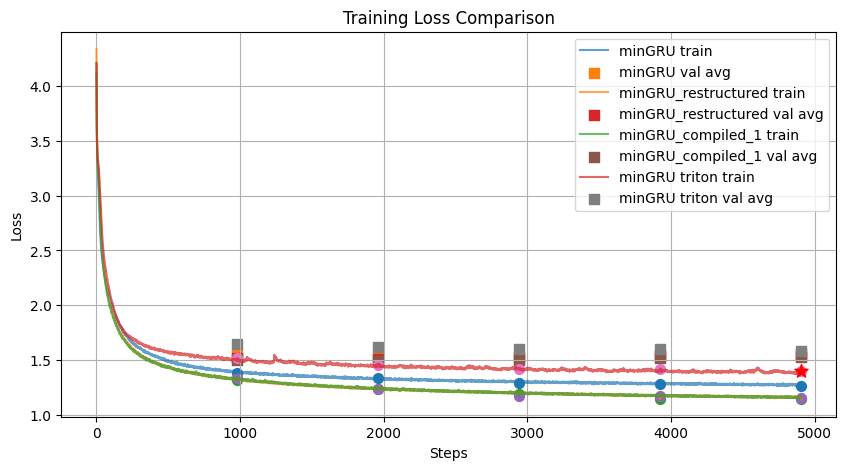

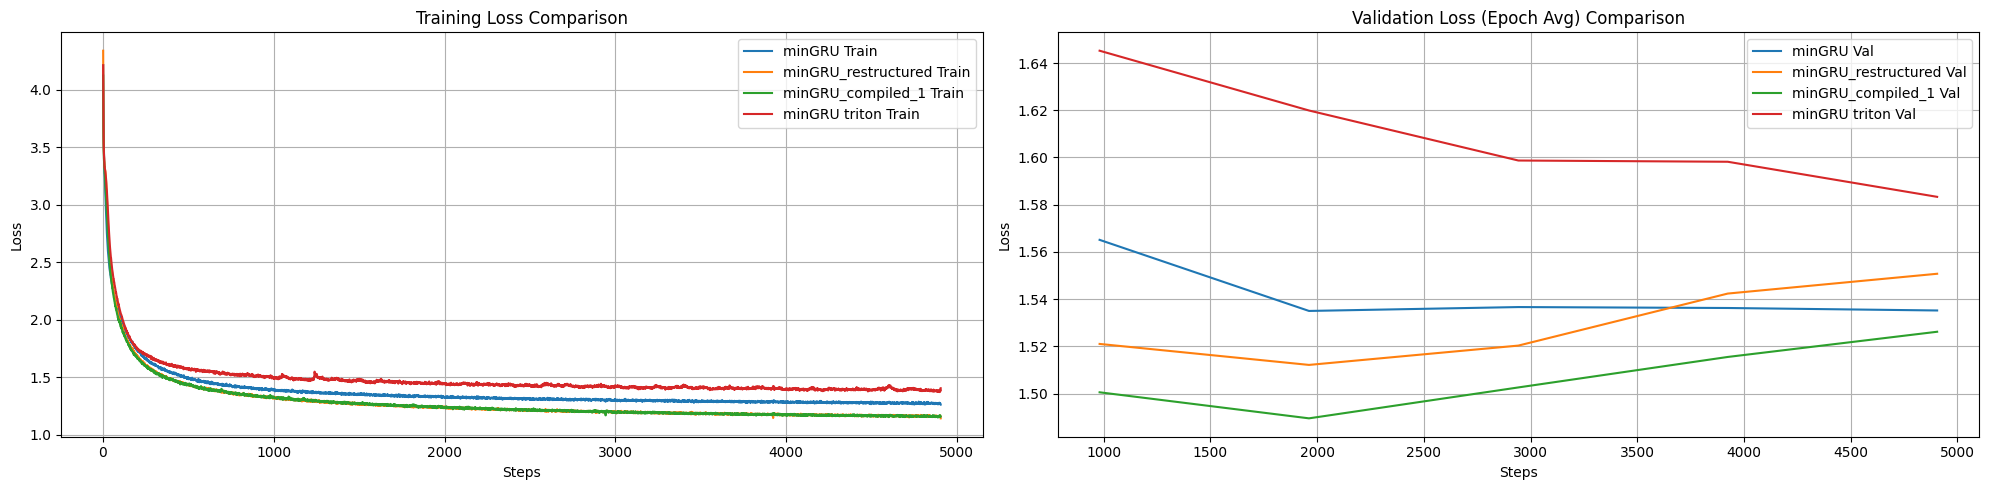

In [38]:
train_and_test("minGRU triton", mingru4, start_text)

## Compiled minGRU with Triton

In [47]:
### Model Initialization
mingru5 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [40]:
from torchinfo import summary

summary(mingru5, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 64]           4,160
├─Linear: 1-2                            [1024, 256, 153]          9,945
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 153]          --
│    └─Sequential: 2-1                   [1024, 153, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 153, 256]          612
│    │    └─Conv1d: 3-2                  [1024, 153, 256]          23,562
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 256, 153]          153
│    │    └─ParallelLogMinGRU: 3-4       [1024, 256, 153]          47,124
│    │    └─RMSNorm: 3-5                 [1024, 256, 153]          153
│    │    └─SwiGLUFFN: 3-6               [1024, 256, 153]          1

In [45]:
del mingru, mingru2, mingru3, mingru4, mingru5  # 메모리 해제를 위해 모델 삭제

import gc  # 가비지 컬렉션을 위한 모듈
gc.collect()  # 가비지 컬렉션 실행

4301

In [46]:
train_and_test2("minGRU_compiled_2", mingru5, start_text)

NameError: name 'mingru5' is not defined